# Assigment 2 - Analyzing the Data

- Use the data in the **proshares_analysis_data.xlsx** It has monthly data on financial indexes and ETFs from August 2011 through September 2021

1. For the series in the "hedge_fund_series" tab, report the following summary statistics:
   1. mean
   2. volatility
   3. Sharpe Ratio
Annualize these statistics 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm 
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import scipy as scs
import sklearn
from sklearn.linear_model import LinearRegression
from scipy import stats 
import warnings
warnings.filterwarnings("ignore")


In [2]:
plt.style.use("seaborn")
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline


In [3]:
# Import Data
file_path = "C:/Users/dcste/OneDrive/Portfolio_Theory/Homework_Jupyter/portfolio_theory/proshares_analysis_data.xlsx"
descriptions = pd.read_excel(file_path, sheet_name = "descriptions")
descriptions.columns = ["Ticker","Security Name"]
descriptions

,Ticker,Security Name
0,EEM US Equity,iShares MSCI Emerging Markets
1,EFA US Equity,iShares MSCI EAFE ETF
2,EUO US Equity,ProShares UltraShort Euro
3,HDG US Equity,ProShares Hedge Replication ET
4,HEFA US Equity,iShares Currency Hedged MSCI E
5,HFRIFWI Index,HFR Fund Wghted Comp
6,IWM US Equity,iShares Russell 2000 ETF
7,MLEIFCTR Index,Merrill Lynch Factor Model Ind
8,MLEIFCTX Index,Merrill Lynch Factor Model Exc
9,QAI US Equity,IndexIQ ETF Trust - IQ Hedge M


In [4]:
hf_data = pd.read_excel(file_path, sheet_name = 'hedge_fund_series')
hf_data = hf_data.rename(columns = {"Unnamed: 0": "date"})
hf_data = hf_data.set_index('date')

factor_data = pd.read_excel(file_path, sheet_name = 'merrill_factors')
factor_data =  factor_data.rename(columns = {"Unnamed: 0": "date"})
factor_data = factor_data.set_index('date')

other_data = pd.read_excel(file_path, sheet_name = 'other_data')
other_data =  other_data.rename(columns = {"Unnamed: 0": "date"})
other_data = other_data.set_index('date')
other_data['SPY US Equity'] = factor_data['SPY US Equity']

In [5]:


def summary_stats(df, annual_frac):
    report = pd.DataFrame()
    report["Mean"] = df.mean()*annual_frac
    report["Volatility"] = df.std() * np.sqrt(annual_frac)
    report["Sharpe Ratio"] = report["Mean"]/report["Volatility"]
    return round(report,4)
    
summary_stats(hf_data.join(factor_data["SPY US Equity"]),12)

   

,Mean,Volatility,Sharpe Ratio
HFRIFWI Index,0.0429,0.0609,0.7038
MLEIFCTR Index,0.0257,0.0569,0.4513
MLEIFCTX Index,0.0243,0.0567,0.4283
HDG US Equity,0.0140,0.0592,0.2365
QAI US Equity,0.0116,0.0489,0.2366
SPY US Equity,0.1213,0.1456,0.8327


## Question 2

2. For the Hedge Fund Information, calculate the following statistical related to tail-risk.
   1. Skewness
   2. Excess Kurtosis
   3. VaR(0.05) - the fifth quantile of historic returns 
   4. CVaR(.05) - the mean of the returns at or belwo the fifth quartile
   5. Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period. 

There is no need to annualize any of these statistics

In [6]:
def tail_risk_report(data, q):
    df = data.copy()
    df.index = data.index.date
    report = pd.DataFrame(columns = df.columns)
    
    report.loc['Skewness'] = df.skew()
    report.loc['Excess Kurtosis'] = df.kurtosis()
    report.loc['VaR'] = df.quantile(q)
    report.loc['Expected Shortfall'] = df[df < df.quantile(q)].mean()
    
    cum_ret = (1 + df).cumprod()
    rolling_max = cum_ret.cummax()
    drawdown = (cum_ret - rolling_max) / rolling_max
    report.loc['Max Drawdown'] = drawdown.min()
    report.loc['MDD Start'] = None
    report.loc['MDD End'] = drawdown.idxmin()
    report.loc['Recovery Date'] = None
    
    for col in df.columns:
        report.loc['MDD Start', col] = (rolling_max.loc[:report.loc['MDD End', col]])[col].idxmax()
        recovery_df = (drawdown.loc[report.loc['MDD End', col]:])[col]
        try:
            report.loc['Recovery Date', col] = recovery_df[recovery_df >= 0].index[0]
            report.loc['Recovery period (days)'] = (report.loc['Recovery Date'] - report.loc['MDD Start']).dt.days

        except:
            report.loc['Recovery Date', col] = None
            report.loc['Recovery period (days)'] = None

    return round(report,4)
        
    
 

In [7]:
def display_correlation(df, list_maximum = True):
    corrmat = df.corr()
    # ignore self correlation
    corrmat[corrmat == 1] = None
    sns.heatmap(corrmat, annot = True)
    
    if list_maximum:
        corr_rank = corrmat.unstack().sort_values().dropna()
        pair_max = corr_rank.index[-1]
        pair_min = corr_rank.index[0]
        print("Lowest correlation pair is {}".format(pair_min))
        print("Highest correlation is {}".format(pair_max))

In [8]:
tail_risk_report(hf_data.join(factor_data["SPY US Equity"]),0.05)

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity,SPY US Equity
Skewness,-1.020683,-0.315513,-0.304807,-0.298573,-0.634129,-0.413602
Excess Kurtosis,6.163102,1.778696,1.741807,1.931106,1.913339,0.936671
VaR,-0.025585,-0.029652,-0.029867,-0.031528,-0.021245,-0.069215
Expected Shortfall,-0.039205,-0.036865,-0.036763,-0.038482,-0.034401,-0.089169
Max Drawdown,-0.115473,-0.124302,-0.124388,-0.14072,-0.137714,-0.239271
MDD Start,2019-12-31,2021-06-30,2021-06-30,2021-06-30,2021-06-30,2021-12-31
MDD End,2020-03-31,2022-09-30,2022-09-30,2022-09-30,2022-09-30,2022-09-30
Recovery Date,2020-08-31,None,None,None,None,None
Recovery period (days),None,None,None,None,None,None


## Question 3

3. For the series in **hedge_fund_series**, run a regression against SPY(found in the **merril_factors** tab.) Include the intercepet and report the following regression-based statistics:
   1. Market Beta
   2. Treynor Ratio
   3. Information Ratio

Annualize these three statistics as appropriate.

In [9]:
def reg_stats(df, annual_frac=None):
    reg_stats = pd.DataFrame(data = None, index = df.columns, columns = ["Beta", "Treynor Ratio", "Information Ratio", "Tracking Error"])
    
    for col in df.columns:
        # Drop the NAs in y
        y = df[col].dropna()
        # you need to include '.loc[y.index]' to align the dates
        X = sm.add_constant(factor_data["SPY US Equity"].loc[y.index])
        reg = sm.OLS(y,X).fit()
        reg_stats.loc[col,"Beta"] = reg.params[1]
        reg_stats.loc[col,"Alpha Annualized"] = reg.params[0]*annual_frac
        reg_stats.loc[col,"Treynor Ratio"] = (df[col].mean() * annual_frac)/reg.params[1]
        reg_stats.loc[col,"R-squared"] = reg.rsquared
        reg_stats.loc[col,"Tracking Error"] =  reg.resid.std()*np.sqrt(12)
        reg_stats.loc[col,"Information Ratio"] = (reg.params[0]/reg.resid.std())*np.sqrt(annual_frac)
    return round(reg_stats,4) 

In [10]:
reg_stats(hf_data,12)

,Beta,Treynor Ratio,Information Ratio,Tracking Error,Alpha Annualized,R-squared
HFRIFWI Index,0.349957,0.122493,0.012954,0.033369,0.0004,0.6999
MLEIFCTR Index,0.354876,0.07232,-0.731515,0.023741,-0.0174,0.8257
MLEIFCTX Index,0.353605,0.068658,-0.784565,0.023707,-0.0186,0.8251
HDG US Equity,0.363099,0.038577,-1.123684,0.026717,-0.0300,0.7966
QAI US Equity,0.291895,0.039657,-0.983817,0.024211,-0.0238,0.7550


## Question 4

4. Discuss the previous statistics, and what they tell us about...
   1. The differences between **SPY** and the **Hedge-Fund Series.**
   2. Which performs better between **HDG** and **QAI.**
   3. Whether **HDG** and **ML** series capture the most notable properties of **HFRI.**


**Question 4: part 1:**

- **SPY** has higher mean return, volatility, and sharpe ratio than all of the hedge fund indices. Addionally, **SPY** has smaller tail risk. Since its excess kurtosis is less than all of the hedge fund data, the frequencies of an extreme event occuring in the SPY with less probabilit. 

**Question 4: Part 2**
- **HDG** has a higher mean return and greater volatility than **QAI.** Thus the sharpe ratio is lower than **QAI.**Also, **HDG** has a higher kurtosis than **QAI** meaning a higher frequency of extreme events in the tails of the distribution. **HDG** has higher *VaR*, *CVaR*, and *Maximum Drawdown* than **QAI** - which could be explained by *HDG's* higher systematic risk $\beta$ coefficient. From the regression statistics, HDG has a higher $\beta$, however a lower *Treynor Ratio* meaning the excess return per unit of systematic risk is actually smaller than **QAI.** Lastly, even though both *Information Ratios* are $<0$, **QAI** outpeforms the *market* more than **HDG**. Overall, **QAI performs better than HDG.**

**Question 4: Part 3**

- From a statistical standpoint, HDG and ML series fail at having comparable **sharpe ratios**(in fact they are both lower than **HFRI**)- meaning their expected returns are not compensated to **HFRI** when we take into account their individual risks. The tails of **HFRI** are not similar to **HDG series or the ML series** given how high the excess kurtosis is for **HFRI.** Lastly **HFRI** has a positive IR ratio - meaning it beats the market compared to the negative IR ratios of all other indices. **HFRI's** Treynor Ratio is better than both HDG and ML series meaning HFRI's excess return is better per unit of systematic risk. I would say **HDG and ML series** do not capture the most notable factors of the **HFRI** indices. 

## Question 5

5. Report the correlations as a heat map.
   1. Show the correlations as a heat map.
   2. Which series have the highest and lowest correlations?
   



Lowest correlation pair is ('HFRIFWI Index', 'SPY US Equity')
Highest correlation is ('MLEIFCTR Index', 'MLEIFCTX Index')


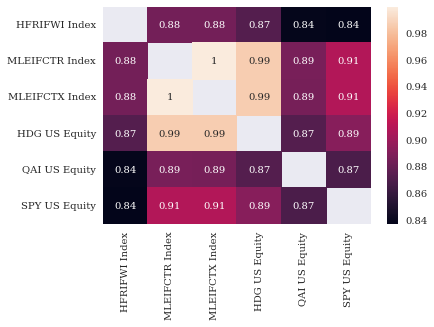

In [11]:
display_correlation(hf_data.join(factor_data["SPY US Equity"]))

## Question 6

6. Replicate HFRI with the six factors listed on the merrill factors tab. Include the constant, and include the unrestrected regression. 
    
$r_{t}^{hfri} = \alpha + (x_{t}^{merr})\beta^{merr} + \epsilon_{t}^{merr}$


$\hat{r}_{t}^{hfri} = \hat{\alpha} + (x_{t}^{merr})\hat{\beta}^{merr}$
   
   
    1. Report the intercept and betas
    2. Are the beta's realistic portion sizes, or do they require huge long-short positions?
    3. Report the R-squared. 
    4. Report the volatiltiy of $\epsilon^{t}$ (the tracking error)


In [12]:
hfri = hf_data["HFRIFWI Index"]
x_merr = sm.add_constant(factor_data)
hfri_regress = sm.OLS(hfri, x_merr).fit()
params_int = pd.DataFrame(hfri_regress.params, columns = ["W-Intercept"])
params_int


,W-Intercept
const,0.001142
SPY US Equity,0.025589
USGG3M Index,0.834569
EEM US Equity,0.074135
EFA US Equity,0.105604
EUO US Equity,0.023240
IWM US Equity,0.147375


In [13]:
static_model = pd.DataFrame(data = None, index = ["R-squared", "Tracking Error"], columns = ["Statistic"])
static_model.loc["R-squared"] = hfri_regress.rsquared
static_model.loc["Tracking Error"] = hfri_regress.resid.std()*(np.sqrt(12))
round(static_model,4)

,Statistic
R-squared,0.821278
Tracking Error,0.025751


In [14]:
hfri_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          HFRIFWI Index   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     97.27
Date:                Mon, 17 Oct 2022   Prob (F-statistic):           4.68e-45
Time:                        15:37:17   Log-Likelihood:                 467.20
No. Observations:                 134   AIC:                            -920.4
Df Residuals:                     127   BIC:                            -900.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      1.314      0.191      -0.001       0.003
SPY US Equity     0.0256      0.042      0.607      0.545      -0.058       0.109
USGG3M Index      0.8346      0.948      0.880      0.381      -1.042       2.711
EEM US Equity     0.0741      0.024      3.050      0.003       0.026       0.122
EFA US Equity     0.1056      0.041      2.585      0.011       0.025       0.186
EUO US Equity     0.0232      0.019      1.211      0.228      -0.015       0.061
IWM US Equity     0.1474      0.026      5.569      0.000       0.095       0.200
==============================================================================
Omnibus:                       19.616   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.415
Skew:                           0.095   Prob(JB):                     1.16e-21
Kurtosis:                       7.151   Cond. No.                     1.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Question 7

7. Let's examine the replication out-of-sample. Starting with $t=61$ month of the sample, do the following:
   1. Use the previous 60 months of data to estimate the regression equation. This gives us time-t estimates of the regression parameters $\alpha$ and $\beta$.
   2. Use the estimated regression parameters, along with the time-t regressor values, $x_{t}^{merr}$, to calculate the time-t replication value, that is, with respect to the regression estimate, built "out of sample"(OOS)
   3. Step forward to $t=62$ and now use $t = 2$ through $t=61$ for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.

- How well does the OOS replication perform with respect to the target?

In [15]:

model = RollingOLS(hfri, x_merr, window = 60)
rolling_betas = model.fit().params.copy()


In [16]:
# Calculating the respective fitted values according to the IS and OSS rolling regression models
rep_IS = (rolling_betas*x_merr).sum(axis = 1, skipna = False)
rep_OOS = (rolling_betas.shift()*x_merr).sum(axis =1 , skipna = False)

In [17]:
replication = hf_data[["HFRIFWI Index"]].copy()
replication["Static Model IS"] = hfri_regress.fittedvalues
replication["Rolling IS"] = rep_IS
replication["Rolling OOS"] = rep_OOS

replication.corr()


,HFRIFWI Index,Static Model IS,Rolling IS,Rolling OOS
HFRIFWI Index,1.000000,0.906244,0.930242,0.887358
Static Model IS,0.906244,1.000000,0.990015,0.986613
Rolling IS,0.930242,0.990015,1.000000,0.993332
Rolling OOS,0.887358,0.986613,0.993332,1.000000


<AxesSubplot:xlabel='date'>

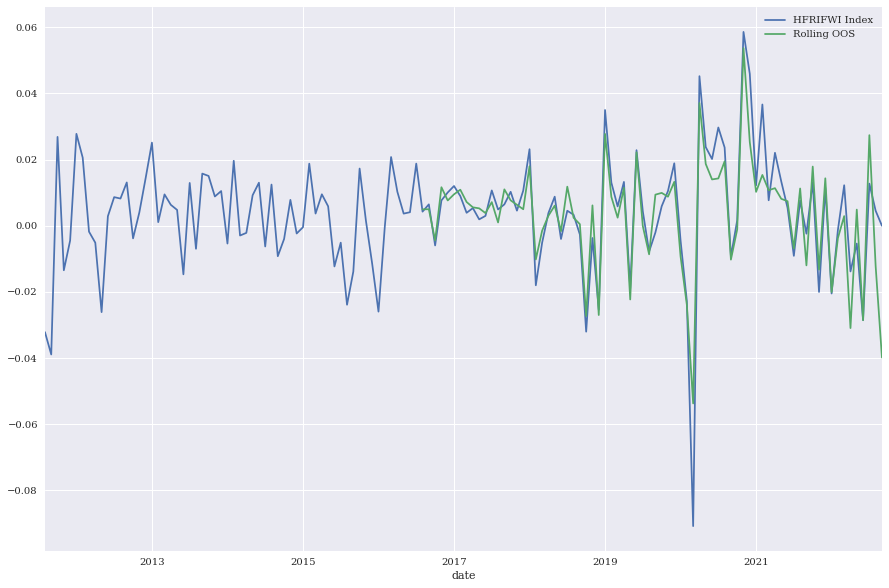

In [18]:
test_train = pd.concat((replication["HFRIFWI Index"], replication["Rolling OOS"]), axis = 1)
test_train.plot(figsize = (15,10))

The **Rolling OSS** regression performs very well achieving a 88% correlation to the actual values. 

## Question 8

8. Estimate the replications without using an intercept and report the following:
   1. The regression beta, How does it compare with the estimated beta with an intercept?
   2. The mean of the fitted value without the intercept and compare the mean fitted value with the regression that does have an intercept. 
   3. Report the correlations of the fitted values without an intercept to the HFRI. How do these correlations compare to that of the fitted valus with an intercept?

Do you think Merrill and Proshares fit their replicators with an intercept or not?


In [19]:
reg_no_int = sm.OLS(hfri, factor_data ).fit()
params_no_int = pd.DataFrame(reg_no_int.params, columns = ["No Intercept"])
pd.concat((params_int,params_no_int), axis =1).T


,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
W-Intercept,0.001142,0.025589,0.834569,0.074135,0.105604,0.023240,0.147375
No Intercept,NaN,0.040448,1.551706,0.073052,0.100760,0.024909,0.144352


As you can see the beta coefficients do not really change when we do or do not include an intercept in the regression equation. 

In [22]:
pd.DataFrame((reg_no_int.fittedvalues.mean()*12,hfri.mean()*12, hfri_regress.fittedvalues.mean()), index = ["No Intercept", "With Intercept","Full Model "], columns = ["Mean"])

,Mean
No Intercept,0.035031
With Intercept,0.042867
Full Model,0.003572


The mean value for the fitted regression with no intercept is slightly smaller than the mean value from the regression with an intercept. 

In [21]:
replication["Static No Intercept"] = reg_no_int.fittedvalues
replication.corr()

,HFRIFWI Index,Static Model IS,Rolling IS,Rolling OOS,Static No Intercept
HFRIFWI Index,1.000000,0.906244,0.930242,0.887358,0.905696
Static Model IS,0.906244,1.000000,0.990015,0.986613,0.999395
Rolling IS,0.930242,0.990015,1.000000,0.993332,0.987919
Rolling OOS,0.887358,0.986613,0.993332,1.000000,0.984103
Static No Intercept,0.905696,0.999395,0.987919,0.984103,1.000000


Since $\alpha_{i}=\mu_{i}-\beta_{i}\mu_{M}$ which is **excess return over the benchmark** Merrill and ProShares should fit their replicators without an intercept because their goal is to make the **HDG** etf replicate the **HFRI** mean returns. If we include the intercept $\alpha$ then **HDG** will not match the mean returns of the index, but still match the variance. 